In [5]:
# --- Cell 1: Import Libraries and Setup ---
# Import all necessary libraries for data manipulation, text preprocessing, and feature engineering.

import pandas as pd
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm # Provides a progress bar for long operations

# Suppress warnings for cleaner output (optional)
import warnings
warnings.filterwarnings('ignore')

print("Required libraries imported successfully.")

# Load the Italian spaCy model for lemmatization and stop word removal.
# If you haven't downloaded it, run: python -m spacy download it_core_news_sm
try:
    nlp_pipeline = spacy.load("it_core_news_sm")
    print("SpaCy 'it_core_news_sm' model loaded successfully for Italian text processing.")
except OSError:
    print("Error: SpaCy 'it_core_news_sm' model not found. Please run 'python -m spacy download it_core_news_sm' in your terminal.")
    # It's crucial to have this model. You might want to stop execution if it's missing.
    raise SystemExit("SpaCy model not loaded. Exiting.")

# --- Cell 2: Load the Unified Dataset ---
# This cell loads the dataset created in the previous notebook.
# This must be run first in any new session or notebook using this data.

UNIFIED_DATASET_PATH = "unified_conversation_dataset.csv"

try:
    unified_df = pd.read_csv(UNIFIED_DATASET_PATH, encoding='utf-8')
    print(f"Unified dataset loaded successfully from '{UNIFIED_DATASET_PATH}'.")
    print(f"Total rows in unified dataset: {len(unified_df)}")
    print(f"Columns: {unified_df.columns.tolist()}")
except FileNotFoundError:
    print(f"Error: The file '{UNIFIED_DATASET_PATH}' was not found. Please ensure it's in the correct directory.")
    raise SystemExit("Dataset file not found. Exiting.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")
    raise SystemExit("Failed to load dataset. Exiting.")

# Display basic info and first few rows to confirm loading
print("\n--- Basic DataFrame Information ---")
unified_df.info()
print("\n--- First 5 Rows of the Unified Dataset ---")
print(unified_df.head())


# --- Cell 3: Define Text Preprocessing Function ---
# This function applies a series of cleaning and normalization steps to the text.

def clean_and_lemmatize_text(text_input):
    """
    Performs comprehensive text preprocessing:
    1. Converts to string and lowercases.
    2. Removes punctuation and numbers.
    3. Tokenizes, removes stop words, and lemmatizes using the loaded spaCy model.

    Args:
        text_input (str): The raw text string to preprocess.

    Returns:
        str: The cleaned and lemmatized text, with tokens joined by spaces.
    """
    if pd.isna(text_input): # Handle potential NaN values in the input text
        return ""
    
    # 1. Convert to string and Lowercase for consistency
    text_input = str(text_input).lower()

    # 2. Remove punctuation and numbers using regex
    # Regex to keep only alphabetic characters and spaces
    text_input = re.sub(r'[^a-z\s]', '', text_input)
    
    # 3. Process with spaCy for tokenization, stop word removal, and lemmatization
    doc = nlp_pipeline(text_input) # Use the loaded nlp_pipeline object

    cleaned_tokens = []
    for token in doc:
        # Filter out stop words, punctuation (already mostly removed), spaces, and empty tokens
        if not token.is_stop and not token.is_punct and not token.is_space and token.text.strip() != '':
            cleaned_tokens.append(token.lemma_) # Append the base form (lemma) of the word

    return " ".join(cleaned_tokens)

print("Text preprocessing function 'clean_and_lemmatize_text' defined.")


# --- Cell 4: Apply Preprocessing to Conversation Column ---
# Apply the defined preprocessing function to the 'conversation' column
# and store the cleaned text in a new 'processed_conversation' column.

print("\n[STEP] Applying advanced text preprocessing to the 'conversation' column...")

# Using tqdm to show progress, as this operation can be time-consuming
unified_df['processed_conversation'] = [
    clean_and_lemmatize_text(text) for text in tqdm(unified_df['conversation'], desc="Processing Text")
]

print("[COMPLETED] Text preprocessing finished.")
print("\nFirst 5 rows showing original and processed conversations:")
print(unified_df[['conversation', 'processed_conversation']].head())


# --- Cell 5: TF-IDF Vectorization ---
# Convert the 'processed_conversation' text into numerical features using TF-IDF.
# These features will be used as input for our machine learning models.

print("\n[STEP] Performing TF-IDF vectorization on processed text...")

# Initialize TF-IDF Vectorizer
# max_features: Limits the vocabulary size to the top 7000 most frequent terms,
#               which helps manage dimensionality and focus on significant words.
# ngram_range=(1, 2): Includes single words (unigrams) and two-word sequences (bigrams).
#                     Bigrams can capture more context (e.g., "non buono" vs "buono").
tfidf_vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1,2))

# Fit the vectorizer to the processed text and transform it into a sparse matrix
X_features_tfidf = tfidf_vectorizer.fit_transform(unified_df['processed_conversation'])

# Get the target labels (y)
y_labels = unified_df['toxic_label']

print("[COMPLETED] TF-IDF vectorization finished.")
print(f"Shape of TF-IDF features (samples, features): {X_features_tfidf.shape}")
print(f"Shape of target labels: {y_labels.shape}")

# Optional: You can save the TF-IDF vectorizer if you need to reuse it later
# for transforming new, unseen text (e.g., in your web application).
# import joblib
# joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
# print("\nTF-IDF vectorizer saved as 'tfidf_vectorizer.joblib'.")

print("\nAll text preprocessing and TF-IDF feature engineering steps completed. Data is now ready for model training.")

Required libraries imported successfully.
SpaCy 'it_core_news_sm' model loaded successfully for Italian text processing.
Unified dataset loaded successfully from 'unified_conversation_dataset.csv'.
Total rows in unified dataset: 1808
Columns: ['conversation_category', 'name1', 'name2', 'conversation', 'most_toxic_sentence', 'explanation_cleaned', 'toxic_label']

--- Basic DataFrame Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   conversation_category  1808 non-null   object
 1   name1                  1808 non-null   object
 2   name2                  1808 non-null   object
 3   conversation           1808 non-null   object
 4   most_toxic_sentence    620 non-null    object
 5   explanation_cleaned    803 non-null    object
 6   toxic_label            1808 non-null   int64 
dtypes: int64(1), object(6)
memory

Processing Text:   0%|          | 0/1808 [00:00<?, ?it/s]

[COMPLETED] Text preprocessing finished.

First 5 rows showing original and processed conversations:
                                        conversation  \
0  "Matteo: Viola, potremmo parlare di quello che...   
1  "Aurelio: Ginevra, devo assolutamente parlarti...   
2  "Matteo: Ciao Chiara! Hai un attimo per parlar...   
3  "Matteo: Giulia, posso parlarti di una cosa ch...   
4  "Matteo: Ciao Viola, posso offrirti qualcosa p...   

                              processed_conversation  
0  matteo viola potere parlare successo sera viol...  
1  aurelio ginevra dovere assolutamente parlarre ...  
2  matteo ciao chiaro attimo parlare gita pensare...  
3  matteo giulia potere parlarti nascosto giuliar...  
4  matteo ciao viola potere offrirto cena stasera...  

[STEP] Performing TF-IDF vectorization on processed text...
[COMPLETED] TF-IDF vectorization finished.
Shape of TF-IDF features (samples, features): (1808, 7000)
Shape of target labels: (1808,)

All text preprocessing and TF-IDF fe


[STEP] Splitting data into training and test sets...
[COMPLETED] Data split finished.
X_train shape: (1446, 7000)
X_test shape: (362, 7000)
y_train shape: (1446,)
y_test shape: (362,)

Distribution of labels in training set:
toxic_label
0    0.556017
1    0.443983
Name: proportion, dtype: float64
Distribution of labels in test set:
toxic_label
0    0.555249
1    0.444751
Name: proportion, dtype: float64

[STEP] Training Logistic Regression model...
[COMPLETED] Logistic Regression model trained.

[STEP] Evaluating Logistic Regression model performance...

[COMPLETED] Model evaluation metrics:
Overall Accuracy: 0.9972
Precision (Toxic): 0.9938
Recall (Toxic): 1.0000
F1-Score (Toxic): 0.9969

--- Detailed Classification Report ---
               precision    recall  f1-score   support

Non-Toxic (0)       1.00      1.00      1.00       201
    Toxic (1)       0.99      1.00      1.00       161

     accuracy                           1.00       362
    macro avg       1.00      1.00     

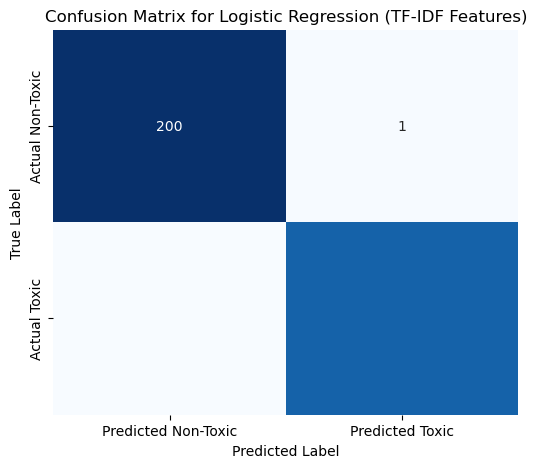


Model evaluation completed.


In [12]:
# --- Cell 6: Split Data into Training and Test Sets ---
# Divide the TF-IDF features (X) and labels (y) into training and testing subsets.

from sklearn.model_selection import train_test_split
import pandas as pd # Import pandas to use value_counts

print("\n[STEP] Splitting data into training and test sets...")

# X_features_tfidf: The TF-IDF features (your input data)
# y_labels: The 'toxic_label' (your target variable)
# test_size=0.2: 20% of the data will be used for testing, 80% for training.
# random_state=42: Ensures reproducibility of the split.
# stratify=y_labels: Ensures that both training and test sets have the same
#                    proportion of toxic and non-toxic samples as the original dataset.
#                    This is important for imbalanced datasets like ours.
X_train, X_test, y_train, y_test = train_test_split(
    X_features_tfidf, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print("[COMPLETED] Data split finished.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Verify stratification (optional)
print("\nDistribution of labels in training set:")
print(y_train.value_counts(normalize=True))
print("Distribution of labels in test set:")
print(y_test.value_counts(normalize=True))


# --- Cell 7: Train a Logistic Regression Model ---
# Train a Logistic Regression model, a common baseline for text classification.

from sklearn.linear_model import LogisticRegression
import warnings # Import warnings to catch LogisticRegression warnings

print("\n[STEP] Training Logistic Regression model...")

# Initialize the Logistic Regression model
# solver='liblinear' is a good choice for smaller datasets and L1/L2 regularization
# random_state=42 for reproducibility
# max_iter increased to ensure convergence for some datasets
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Ignore convergence warnings
    log_reg_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)

# Train the model using the training data
log_reg_model.fit(X_train, y_train)

print("[COMPLETED] Logistic Regression model trained.")


# --- Cell 8: Evaluate the Model ---
# Evaluate the trained model's performance on the test set with comprehensive output.

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score # Ensure all metrics are imported
import seaborn as sns
import matplotlib.pyplot as plt

print("\n[STEP] Evaluating Logistic Regression model performance...")

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

# Calculate individual evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred) # Precision for the positive class (Toxic)
recall = recall_score(y_test, y_pred)       # Recall for the positive class (Toxic)
f1 = f1_score(y_test, y_pred)               # F1-Score for the positive class (Toxic)


print("\n[COMPLETED] Model evaluation metrics:")

# Display individual metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Precision (Toxic): {precision:.4f}")
print(f"Recall (Toxic): {recall:.4f}")
print(f"F1-Score (Toxic): {f1:.4f}")


print("\n--- Detailed Classification Report ---")
# Provides Precision, Recall, F1-Score for each class, and overall accuracy
print(classification_report(y_test, y_pred, target_names=['Non-Toxic (0)', 'Toxic (1)']))

print("\n--- Confusion Matrix ---")
# Shows true positives, true negatives, false positives, false negatives
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic'])
plt.title('Confusion Matrix for Logistic Regression (TF-IDF Features)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nModel evaluation completed.")


[STEP] Re-splitting raw processed text data into training and test sets for pipeline models...
[COMPLETED] Raw text data split finished.
X_train_raw_text shape: (1446,)
X_test_raw_text shape: (362,)
y_train_split shape: (1446,)
y_test_split shape: (362,)

Distribution of labels in training set (raw text split):
toxic_label
0    0.556017
1    0.443983
Name: proportion, dtype: float64
Distribution of labels in test set (raw text split):
toxic_label
0    0.555249
1    0.444751
Name: proportion, dtype: float64

[STEP] Setting up Pipeline for Multinomial Naive Bayes and GridSearchCV...

[STEP] Performing GridSearchCV for Multinomial Naive Bayes (this may take a few minutes)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

[COMPLETED] GridSearchCV for Multinomial Naive Bayes finished.

Best Parameters for Multinomial Naive Bayes: {'clf__alpha': 0.01, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 2)}
Best F1-Weighted Score on validation sets: 0.9979

[COMPLETED] Mod

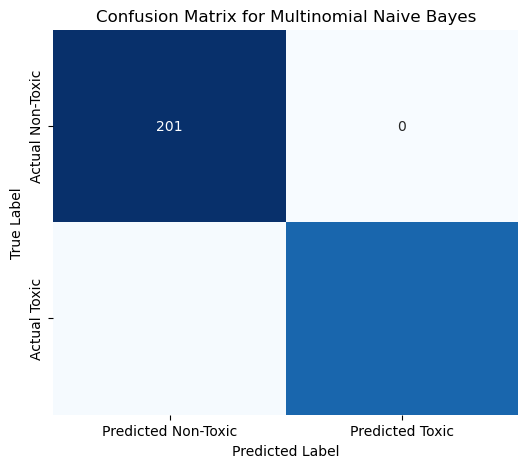


Multinomial Naive Bayes model training and evaluation completed.


In [13]:
# --- Cell 6: Split Data into Training and Test Sets for Pipeline Models ---
# For models that use a Pipeline (like Naive Bayes with TF-IDF inside the pipeline),
# we need to split the raw processed text, not the already vectorized features.

from sklearn.model_selection import train_test_split
import pandas as pd # Import pandas for value_counts

print("\n[STEP] Re-splitting raw processed text data into training and test sets for pipeline models...")

# Use the 'processed_conversation' column (raw text after preprocessing) and the 'toxic_label'
X_processed_text = unified_df['processed_conversation']
y_labels = unified_df['toxic_label'] # Re-using y_labels from previous steps

# Split the data
# test_size=0.2: 20% of the data for testing
# random_state=42: Ensures reproducibility
# stratify=y_labels: Maintains the same proportion of classes in train and test sets
X_train_raw_text, X_test_raw_text, y_train_split, y_test_split = train_test_split(
    X_processed_text, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print("[COMPLETED] Raw text data split finished.")
print(f"X_train_raw_text shape: {X_train_raw_text.shape}")
print(f"X_test_raw_text shape: {X_test_raw_text.shape}")
print(f"y_train_split shape: {y_train_split.shape}")
print(f"y_test_split shape: {y_test_split.shape}")

# Verify stratification
print("\nDistribution of labels in training set (raw text split):")
print(y_train_split.value_counts(normalize=True))
print("Distribution of labels in test set (raw text split):")
print(y_test_split.value_counts(normalize=True))


# --- Cell 7: Train and Evaluate Multinomial Naive Bayes Model with GridSearchCV (Comprehensive Output) ---
# Train a Multinomial Naive Bayes model and optimize its hyperparameters using GridSearchCV.

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer # Nuova importazione necessaria per Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score # Nuove importazioni per metriche individuali
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Per gestire i warning

print("\n[STEP] Setting up Pipeline for Multinomial Naive Bayes and GridSearchCV...")

# Define the pipeline for Multinomial Naive Bayes
# The pipeline includes a TfidfVectorizer (which will be fitted by GridSearchCV)
# and the Multinomial Naive Bayes classifier.
pipeline_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()), # TF-IDF vectorizer component
    ('clf', MultinomialNB())      # Classifier component
])

# Define the hyperparameters grid to search for Multinomial Naive Bayes
# 'tfidf__max_features': Limits the vocabulary size for TF-IDF.
# 'tfidf__ngram_range': Explores different n-gram combinations.
# 'clf__alpha': Smoothing parameter for Naive Bayes.
param_grid_mnb = {
    'tfidf__max_features': [3000, 5000, 7000], # Explore different vocabulary sizes
    'tfidf__ngram_range': [(1,1), (1,2)],     # Explore unigrams only vs unigrams and bigrams
    'clf__alpha': [0.01, 0.1, 0.5, 1.0]      # Explore different smoothing values
}

# Initialize GridSearchCV
# estimator: The pipeline to optimize
# param_grid: The dictionary of hyperparameters to search
# cv: Number of cross-validation folds (e.g., 5-fold cross-validation)
# scoring: Metric to optimize (e.g., 'f1_weighted' is good for imbalanced data)
# n_jobs: Number of CPU cores to use (-1 means all available cores)
grid_search_mnb = GridSearchCV(
    pipeline_mnb,
    param_grid_mnb,
    cv=5, # 5-fold cross-validation
    scoring='f1_weighted', # Optimize for weighted F1-score due to slight imbalance
    n_jobs=-1, # Use all available CPU cores
    verbose=1 # Display progress messages
)

print("\n[STEP] Performing GridSearchCV for Multinomial Naive Bayes (this may take a few minutes)...")
# Fit GridSearchCV on the training data (X_train_raw_text and y_train_split)
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Ignore convergence warnings from Naive Bayes or pipeline
    grid_search_mnb.fit(X_train_raw_text, y_train_split)

print("\n[COMPLETED] GridSearchCV for Multinomial Naive Bayes finished.")

# Get the best estimator (model)
best_mnb_model = grid_search_mnb.best_estimator_
print(f"\nBest Parameters for Multinomial Naive Bayes: {grid_search_mnb.best_params_}")
print(f"Best F1-Weighted Score on validation sets: {grid_search_mnb.best_score_:.4f}")

# Make predictions on the test set using the best model
y_pred_mnb = best_mnb_model.predict(X_test_raw_text)

print("\n[COMPLETED] Model evaluation metrics (Multinomial Naive Bayes):")

# Calculate individual metrics for best model
accuracy_mnb = accuracy_score(y_test_split, y_pred_mnb)
precision_mnb = precision_score(y_test_split, y_pred_mnb)
recall_mnb = recall_score(y_test_split, y_pred_mnb)
f1_mnb = f1_score(y_test_split, y_pred_mnb)

# Display individual metrics
print(f"Overall Accuracy: {accuracy_mnb:.4f}")
print(f"Precision (Toxic): {precision_mnb:.4f}")
print(f"Recall (Toxic): {recall_mnb:.4f}")
print(f"F1-Score (Toxic): {f1_mnb:.4f}")


print("\n--- Detailed Classification Report (Multinomial Naive Bayes) ---")
print(classification_report(y_test_split, y_pred_mnb, target_names=['Non-Toxic (0)', 'Toxic (1)']))

print("\n--- Confusion Matrix (Multinomial Naive Bayes) ---")
cm_mnb = confusion_matrix(y_test_split, y_pred_mnb)
print(cm_mnb)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic'])
plt.title('Confusion Matrix for Multinomial Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nMultinomial Naive Bayes model training and evaluation completed.")


[STEP] Setting up Pipeline for LightGBM and GridSearchCV...

[STEP] Performing GridSearchCV for LightGBM (this may take some time)...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Info] Number of positive: 642, number of negative: 804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16898
[LightGBM] [Info] Number of data points in the train set: 1446, number of used features: 705
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443983 -> initscore=-0.225011
[LightGBM] [Info] Start training from score -0.225011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

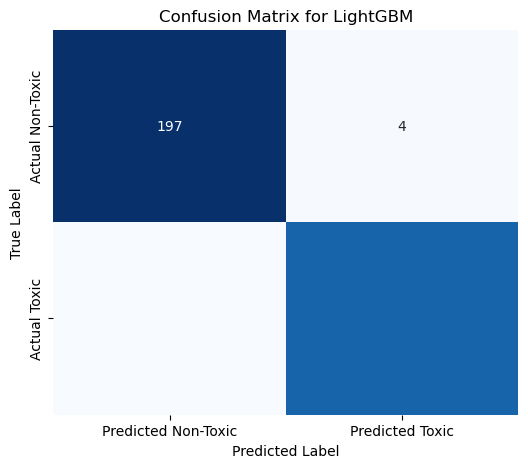


LightGBM model training and evaluation completed.


In [14]:
# --- Cell 8: Train and Evaluate LightGBM Model with GridSearchCV (Comprehensive Output) ---
# Train a Light Gradient Boosting Machine (LightGBM) model and optimize its hyperparameters.

import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer # Nuova importazione necessaria per Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score # Importazioni per metriche individuali
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Per gestire i warning

print("\n[STEP] Setting up Pipeline for LightGBM and GridSearchCV...")

# Define the pipeline for LightGBM
# Includes TfidfVectorizer and LightGBM Classifier.
pipeline_lgbm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', lgb.LGBMClassifier(random_state=42)) # Initialize LGBMClassifier
])

# Define the hyperparameters grid to search for LightGBM
param_grid_lgbm = {
    'tfidf__max_features': [5000, 7000, 10000], # Vocabulary size for TF-IDF
    'tfidf__ngram_range': [(1,1), (1,2)],     # N-gram range for TF-IDF
    'clf__n_estimators': [100, 200, 300],    # Number of boosting rounds
    'clf__learning_rate': [0.05, 0.1, 0.2],  # Step size shrinkage
    'clf__num_leaves': [20, 31, 40]          # Max number of leaves in one tree
}

# Initialize GridSearchCV for LightGBM
grid_search_lgbm = GridSearchCV(
    pipeline_lgbm,
    param_grid_lgbm,
    cv=5, # 5-fold cross-validation
    scoring='f1_weighted', # Optimize for weighted F1-score
    n_jobs=-1, # Use all available CPU cores
    verbose=1 # Display progress
)

print("\n[STEP] Performing GridSearchCV for LightGBM (this may take some time)...")
# Fit GridSearchCV on the training data (raw text)
# Use X_train_raw_text and y_train_split from Cell 6
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Ignore convergence warnings from LGBM or pipeline
    grid_search_lgbm.fit(X_train_raw_text, y_train_split)

print("\n[COMPLETED] GridSearchCV for LightGBM finished.")

# Get the best estimator (model)
best_lgbm_model = grid_search_lgbm.best_estimator_
print(f"\nBest Parameters for LightGBM: {grid_search_lgbm.best_params_}")
print(f"Best F1-Weighted Score on validation sets: {grid_search_lgbm.best_score_:.4f}")

# Make predictions on the test set using the best model
y_pred_lgbm = best_lgbm_model.predict(X_test_raw_text)

print("\n[COMPLETED] Model evaluation metrics (LightGBM):")

# Calculate individual evaluation metrics
accuracy_lgbm = accuracy_score(y_test_split, y_pred_lgbm)
precision_lgbm = precision_score(y_test_split, y_pred_lgbm)
recall_lgbm = recall_score(y_test_split, y_pred_lgbm)
f1_lgbm = f1_score(y_test_split, y_pred_lgbm)

# Display individual metrics
print(f"Overall Accuracy: {accuracy_lgbm:.4f}")
print(f"Precision (Toxic): {precision_lgbm:.4f}")
print(f"Recall (Toxic): {recall_lgbm:.4f}")
print(f"F1-Score (Toxic): {f1_lgbm:.4f}")

print("\n--- Detailed Classification Report (LightGBM) ---")
print(classification_report(y_test_split, y_pred_lgbm, target_names=['Non-Toxic (0)', 'Toxic (1)']))

print("\n--- Confusion Matrix (LightGBM) ---")
cm_lgbm = confusion_matrix(y_test_split, y_pred_lgbm)
print(cm_lgbm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic'])
plt.title('Confusion Matrix for LightGBM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nLightGBM model training and evaluation completed.")

In [6]:
# --- Cell 9: Load FastText Embeddings and Generate Document Embeddings ---
# Load pre-trained FastText word embeddings for Italian and create document-level embeddings.

import numpy as np
from tqdm.notebook import tqdm
import pandas as pd # Ensure pandas is imported for pd.isna

print("\n[STEP] Loading FastText embeddings and generating document embeddings...")

# --- Configuration for FastText ---
# IMPORTANT: Replace 'PATH_TO_FASTTEXT_MODEL.vec' with the actual path to your downloaded FastText file.
# Example: 'embeddings/cc.it.300.vec' or 'wiki.it.vec' if in the same folder.
FASTTEXT_MODEL_PATH = 'wiki.it.vec' # <--- ASSICURATI CHE SIA QUESTO IL NOME ESATTO DEL TUO FILE

# Dictionary to store word embeddings
embeddings_index = {}

try:
    with open(FASTTEXT_MODEL_PATH, encoding='utf-8', errors='ignore') as f:
        # FastText files often have the first line as metadata (num_words dim), skip it.
        # It's safer to read line by line.
        for i, line in enumerate(tqdm(f, desc="Loading Embeddings")):
            if i == 0 and len(line.split()) == 2: # Check if it's the header line
                try: # Try to parse header if it's there
                    num_words, embedding_dim_header = map(int, line.split())
                    print(f"Detected header: {num_words} words, {embedding_dim_header} dimensions.")
                    continue # Skip header
                except ValueError: # If it looks like a header but isn't valid, treat as a normal line
                    pass # Continue to process as a normal line if parsing fails

            values = line.split()
            if len(values) > 1: # Ensure there are values to parse as coefficients
                word = values[0]
                try:
                    # Attempt to convert the rest of the values to floats
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
                except ValueError:
                    # If conversion fails for a line, print a warning and skip it
                    print(f"Warning: Skipping malformed line (non-numeric coefficients): {line.strip()}")
                    continue # Skip to the next line
            else:
                # If a line doesn't have a word and coefficients (e.g., empty or malformed)
                print(f"Warning: Skipping empty or malformed line: {line.strip()}")
                continue # Skip to the next line

    if not embeddings_index:
        raise ValueError("No embeddings were loaded. The file might be empty or entirely malformed.")

    print(f"[COMPLETED] Loaded {len(embeddings_index)} word vectors from {FASTTEXT_MODEL_PATH}.")
    EMBEDDING_DIM = len(next(iter(embeddings_index.values()))) # Get dimension from first vector
    print(f"Embedding dimension: {EMBEDDING_DIM}")

except FileNotFoundError:
    print(f"Error: FastText model not found at '{FASTTEXT_MODEL_PATH}'.")
    print("Please ensure you have downloaded 'cc.it.300.vec' or 'wiki.it.vec' and placed it correctly.")
    raise SystemExit("FastText model not loaded. Exiting.")
except Exception as e:
    print(f"An error occurred while loading embeddings: {e}")
    raise SystemExit("Failed to load FastText embeddings. Exiting.")


# Function to create an average word embedding for a given text
def get_average_word_embedding(text, word_embeddings, embedding_dim):
    """
    Computes the average word embedding for a given text.
    Tokens are split by space. Only words present in the embeddings dictionary are considered.
    """
    if pd.isna(text) or not text.strip():
        return np.zeros(embedding_dim) # Return a zero vector for empty/NaN text

    words = text.split()
    word_vectors = []
    for word in words:
        if word in word_embeddings:
            word_vectors.append(word_embeddings[word])
    
    if not word_vectors: # If no words found in embeddings (e.g., all stopwords or OOV)
        return np.zeros(embedding_dim)
    
    return np.mean(word_vectors, axis=0) # Average the word vectors

# Apply the function to the 'processed_conversation' column to get document embeddings
print("\n[STEP] Generating document embeddings for 'processed_conversation'...")
X_embeddings = np.array([
    get_average_word_embedding(text, embeddings_index, EMBEDDING_DIM)
    for text in tqdm(unified_df['processed_conversation'], desc="Generating Doc Embeddings")
])

# Get the target labels (y) again, ensuring consistency
y_labels_embeddings = unified_df['toxic_label']

print("[COMPLETED] Document embeddings generated.")
print(f"Shape of Document Embeddings (samples, embedding_dim): {X_embeddings.shape}")
print(f"Shape of target labels: {y_labels_embeddings.shape}")

print("\nData is now ready for model training using Word Embeddings.")


[STEP] Loading FastText embeddings and generating document embeddings...


Loading Embeddings: 0it [00:00, ?it/s]

Detected header: 871053 words, 300 dimensions.
[COMPLETED] Loaded 870984 word vectors from wiki.it.vec.
Embedding dimension: 300

[STEP] Generating document embeddings for 'processed_conversation'...


Generating Doc Embeddings:   0%|          | 0/1808 [00:00<?, ?it/s]

[COMPLETED] Document embeddings generated.
Shape of Document Embeddings (samples, embedding_dim): (1808, 300)
Shape of target labels: (1808,)

Data is now ready for model training using Word Embeddings.



[STEP] Splitting data into training and testing sets...
[COMPLETED] Data split successfully.
X_train shape: (1446, 300), y_train shape: (1446,)
X_test shape: (362, 300), y_test shape: (362,)

[STEP] Training Logistic Regression model...
[COMPLETED] Model training finished.

[STEP] Evaluating the model performance...
[COMPLETED] Model evaluation metrics:
Overall Accuracy: 0.9807
Precision (Toxic): 0.9873
Recall (Toxic): 0.9689
F1-Score (Toxic): 0.9781

--- Detailed Classification Report ---
               precision    recall  f1-score   support

Non-Toxic (0)       0.98      0.99      0.98       201
    Toxic (1)       0.99      0.97      0.98       161

     accuracy                           0.98       362
    macro avg       0.98      0.98      0.98       362
 weighted avg       0.98      0.98      0.98       362


--- Confusion Matrix ---
[[199   2]
 [  5 156]]


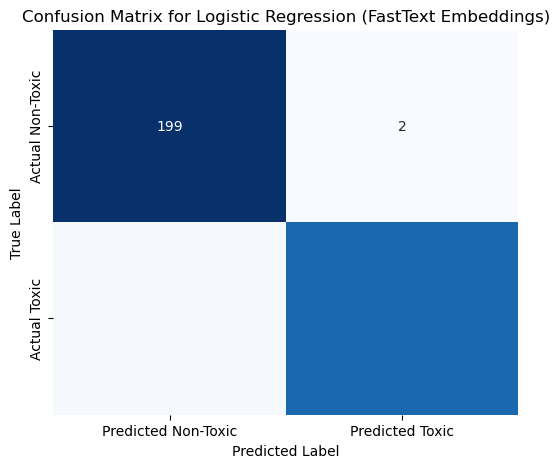


Model training and evaluation are complete. The trained 'model' object is now available.


In [11]:
# --- Cell 10: Model Training and Evaluation using Word Embeddings (Comprehensive Output) ---
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

print("\n[STEP] Splitting data into training and testing sets...")
# Split the data into training and testing sets
# Using stratify=y_labels_embeddings ensures that the proportion of toxic/non-toxic samples
# is the same in both training and testing sets, which is important for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y_labels_embeddings, test_size=0.2, random_state=42, stratify=y_labels_embeddings
)

print("[COMPLETED] Data split successfully.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("\n[STEP] Training Logistic Regression model...")
# Initialize and train a Logistic Regression model
# We set max_iter to a higher value to ensure convergence for larger datasets
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Ignore convergence warnings
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

print("[COMPLETED] Model training finished.")

print("\n[STEP] Evaluating the model performance...")
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate individual evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("[COMPLETED] Model evaluation metrics:")

# Display individual metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Precision (Toxic): {precision:.4f}") # Precision for the positive class (toxic)
print(f"Recall (Toxic): {recall:.4f}")       # Recall for the positive class (toxic)
print(f"F1-Score (Toxic): {f1:.4f}")         # F1-Score for the positive class (toxic)

print("\n--- Detailed Classification Report ---")
# Provides Precision, Recall, F1-Score for each class, and overall accuracy
print(classification_report(y_test, y_pred, target_names=['Non-Toxic (0)', 'Toxic (1)']))

print("\n--- Confusion Matrix ---")
# Shows true positives, true negatives, false positives, false negatives
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic'])
plt.title('Confusion Matrix for Logistic Regression (FastText Embeddings)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print("\nModel training and evaluation are complete. The trained 'model' object is now available.")


[STEP] Setting up Pipeline for SVM and GridSearchCV...

[STEP] Performing GridSearchCV for SVM (this may take significant time)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

[COMPLETED] GridSearchCV for SVM finished.

Best Parameters for SVM: {'clf__C': 1, 'clf__kernel': 'linear', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Best F1-Weighted Score on validation sets: 0.9986

[COMPLETED] Model evaluation metrics (SVM):
Overall Accuracy: 1.0000
Precision (Toxic): 1.0000
Recall (Toxic): 1.0000
F1-Score (Toxic): 1.0000

--- Detailed Classification Report (SVM) ---
               precision    recall  f1-score   support

Non-Toxic (0)       1.00      1.00      1.00       201
    Toxic (1)       1.00      1.00      1.00       161

     accuracy                           1.00       362
    macro avg       1.00      1.00      1.00       362
 weighted avg       1.00      1.00      1.00       362


--- Confusion Matrix (SVM) ---
[[201   0]
 [  0 161]]


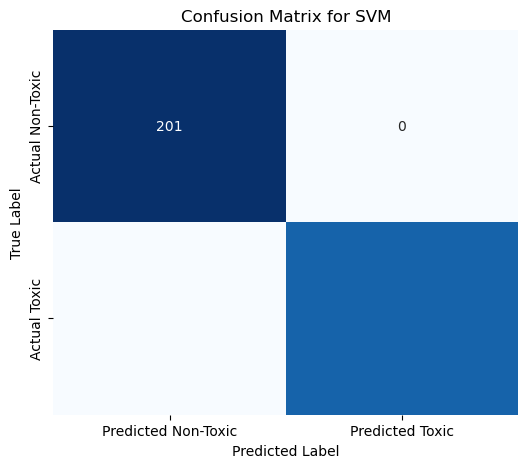


SVM model training and evaluation completed.


In [16]:
# --- Cell 9: Train and Evaluate Support Vector Machine (SVM) Model with GridSearchCV ---
# Train a Support Vector Machine (SVM) model and optimize its hyperparameters.

from sklearn.svm import SVC # Support Vector Classifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

print("\n[STEP] Setting up Pipeline for SVM and GridSearchCV...")

# Define the pipeline for SVM
# Includes TfidfVectorizer and SVM Classifier.
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(random_state=42)) # Initialize SVC
])

# Define the hyperparameters grid to search for SVM
# Note: SVM can be computationally intensive, especially with large grids and 'rbf' kernel.
# We'll start with a manageable grid.
param_grid_svm = {
    'tfidf__max_features': [7000, 10000], # Vocabulary size for TF-IDF
    'tfidf__ngram_range': [(1,1), (1,2)], # N-gram range for TF-IDF
    'clf__C': [0.1, 1, 10], # Regularization parameter
    'clf__kernel': ['linear', 'rbf'] # Kernel type ('linear' is often good for text)
}

# Initialize GridSearchCV for SVM
grid_search_svm = GridSearchCV(
    pipeline_svm,
    param_grid_svm,
    cv=5, # 5-fold cross-validation
    scoring='f1_weighted', # Optimize for weighted F1-score
    n_jobs=-1, # Use all available CPU cores
    verbose=1 # Display progress
)

print("\n[STEP] Performing GridSearchCV for SVM (this may take significant time)...")
# Fit GridSearchCV on the training data (raw text)
# Use X_train_raw_text and y_train_split from Cell 6
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Ignore any convergence warnings
    grid_search_svm.fit(X_train_raw_text, y_train_split)

print("\n[COMPLETED] GridSearchCV for SVM finished.")

# Get the best estimator (model)
best_svm_model = grid_search_svm.best_estimator_
print(f"\nBest Parameters for SVM: {grid_search_svm.best_params_}")
print(f"Best F1-Weighted Score on validation sets: {grid_search_svm.best_score_:.4f}")

# Make predictions on the test set using the best model
y_pred_svm = best_svm_model.predict(X_test_raw_text)

print("\n[COMPLETED] Model evaluation metrics (SVM):")

# Calculate individual evaluation metrics
accuracy_svm = accuracy_score(y_test_split, y_pred_svm)
precision_svm = precision_score(y_test_split, y_pred_svm)
recall_svm = recall_score(y_test_split, y_pred_svm)
f1_svm = f1_score(y_test_split, y_pred_svm)

# Display individual metrics
print(f"Overall Accuracy: {accuracy_svm:.4f}")
print(f"Precision (Toxic): {precision_svm:.4f}")
print(f"Recall (Toxic): {recall_svm:.4f}")
print(f"F1-Score (Toxic): {f1_svm:.4f}")

print("\n--- Detailed Classification Report (SVM) ---")
print(classification_report(y_test_split, y_pred_svm, target_names=['Non-Toxic (0)', 'Toxic (1)']))

print("\n--- Confusion Matrix (SVM) ---")
cm_svm = confusion_matrix(y_test_split, y_pred_svm)
print(cm_svm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic'])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nSVM model training and evaluation completed.")


[STEP] Splitting data for Multinomial Naive Bayes with FastText embeddings...
[COMPLETED] Data split successfully.

[STEP] Setting up Pipeline for Multinomial Naive Bayes with FastText embeddings...

[STEP] Training Multinomial Naive Bayes model with FastText embeddings...
[COMPLETED] Multinomial Naive Bayes model training finished.

[STEP] Evaluating the model performance (Multinomial Naive Bayes with FastText)...

[COMPLETED] Model evaluation metrics (Multinomial Naive Bayes with FastText):
Overall Accuracy: 0.9448
Precision (Toxic): 0.9548
Recall (Toxic): 0.9193
F1-Score (Toxic): 0.9367

--- Detailed Classification Report (Multinomial Naive Bayes with FastText) ---
               precision    recall  f1-score   support

Non-Toxic (0)       0.94      0.97      0.95       201
    Toxic (1)       0.95      0.92      0.94       161

     accuracy                           0.94       362
    macro avg       0.95      0.94      0.94       362
 weighted avg       0.95      0.94      0.94 

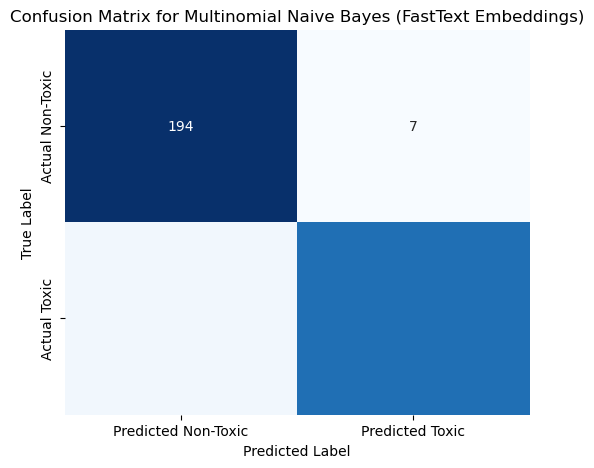


Multinomial Naive Bayes with FastText evaluation complete.


In [17]:
# --- Cell X: Train and Evaluate Multinomial Naive Bayes with FastText Embeddings ---
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler # Importazione necessaria per scalare gli embedding
from sklearn.pipeline import Pipeline # Per combinare scaler e classificatore
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

print("\n[STEP] Splitting data for Multinomial Naive Bayes with FastText embeddings...")
# Split the FastText embeddings data into training and testing sets
X_train_ft_mnb, X_test_ft_mnb, y_train_ft_mnb, y_test_ft_mnb = train_test_split(
    X_embeddings, y_labels_embeddings, test_size=0.2, random_state=42, stratify=y_labels_embeddings
)
print("[COMPLETED] Data split successfully.")

print("\n[STEP] Setting up Pipeline for Multinomial Naive Bayes with FastText embeddings...")
# Define a pipeline that first scales the embeddings and then applies Multinomial Naive Bayes
# MinMaxScaler transforms features by scaling each feature to a given range (default 0 to 1).
# This is crucial as MultinomialNB requires non-negative input features.
pipeline_mnb_ft = Pipeline([
    ('scaler', MinMaxScaler()), # Scale embeddings to a non-negative range [0, 1]
    ('clf', MultinomialNB())    # Multinomial Naive Bayes classifier
])

print("\n[STEP] Training Multinomial Naive Bayes model with FastText embeddings...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Ignore potential warnings (e.g., regarding convergence if applicable)
    pipeline_mnb_ft.fit(X_train_ft_mnb, y_train_ft_mnb)

print("[COMPLETED] Multinomial Naive Bayes model training finished.")

print("\n[STEP] Evaluating the model performance (Multinomial Naive Bayes with FastText)...")
# Make predictions on the test set using the pipeline
y_pred_mnb_ft = pipeline_mnb_ft.predict(X_test_ft_mnb)

print("\n[COMPLETED] Model evaluation metrics (Multinomial Naive Bayes with FastText):")

# Calculate individual evaluation metrics
accuracy_mnb_ft = accuracy_score(y_test_ft_mnb, y_pred_mnb_ft)
precision_mnb_ft = precision_score(y_test_ft_mnb, y_pred_mnb_ft)
recall_mnb_ft = recall_score(y_test_ft_mnb, y_pred_mnb_ft)
f1_mnb_ft = f1_score(y_test_ft_mnb, y_pred_mnb_ft)

# Display individual metrics
print(f"Overall Accuracy: {accuracy_mnb_ft:.4f}")
print(f"Precision (Toxic): {precision_mnb_ft:.4f}")
print(f"Recall (Toxic): {recall_mnb_ft:.4f}")
print(f"F1-Score (Toxic): {f1_mnb_ft:.4f}")

print("\n--- Detailed Classification Report (Multinomial Naive Bayes with FastText) ---")
print(classification_report(y_test_ft_mnb, y_pred_mnb_ft, target_names=['Non-Toxic (0)', 'Toxic (1)']))

print("\n--- Confusion Matrix (Multinomial Naive Bayes with FastText) ---")
cm_mnb_ft = confusion_matrix(y_test_ft_mnb, y_pred_mnb_ft)
print(cm_mnb_ft)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mnb_ft, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic'])
plt.title('Confusion Matrix for Multinomial Naive Bayes (FastText Embeddings)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nMultinomial Naive Bayes with FastText evaluation complete.")


[STEP] Splitting data for LightGBM with FastText embeddings...
[COMPLETED] Data split successfully.

[STEP] Training LightGBM model with FastText embeddings...
[LightGBM] [Info] Number of positive: 642, number of negative: 804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1446, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443983 -> initscore=-0.225011
[LightGBM] [Info] Start training from score -0.225011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[COMPLETED] LightGBM model training finished.

[STEP] Evaluating the model performance (LightGBM with FastText)...

[COMPLETED] Model evaluation metrics (LightGBM with FastText):
Overall Accuracy: 0.9807
Precision (Toxic): 0.9753
Recall (Toxic): 0.9814
F1-Score (Toxic): 0.

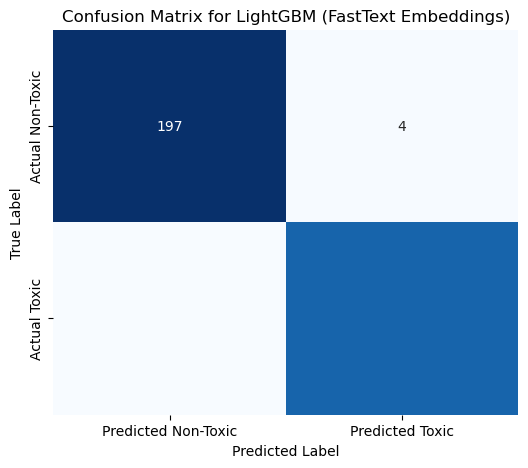


LightGBM with FastText evaluation complete.


In [18]:
# --- Cell Y: Train and Evaluate LightGBM with FastText Embeddings ---
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

print("\n[STEP] Splitting data for LightGBM with FastText embeddings...")
# Split the FastText embeddings data into training and testing sets
X_train_ft_lgbm, X_test_ft_lgbm, y_train_ft_lgbm, y_test_ft_lgbm = train_test_split(
    X_embeddings, y_labels_embeddings, test_size=0.2, random_state=42, stratify=y_labels_embeddings
)
print("[COMPLETED] Data split successfully.")

print("\n[STEP] Training LightGBM model with FastText embeddings...")
# Initialize and train a LightGBM classifier
# We'll use a default set of parameters or those found to be reasonable previously,
# as GridSearchCV here would significantly extend the execution time.
lgbm_ft_model = lgb.LGBMClassifier(random_state=42)

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Ignore potential warnings (e.g., regarding feature names)
    lgbm_ft_model.fit(X_train_ft_lgbm, y_train_ft_lgbm)

print("[COMPLETED] LightGBM model training finished.")

print("\n[STEP] Evaluating the model performance (LightGBM with FastText)...")
# Make predictions on the test set
y_pred_lgbm_ft = lgbm_ft_model.predict(X_test_ft_lgbm)

print("\n[COMPLETED] Model evaluation metrics (LightGBM with FastText):")

# Calculate individual evaluation metrics
accuracy_lgbm_ft = accuracy_score(y_test_ft_lgbm, y_pred_lgbm_ft)
precision_lgbm_ft = precision_score(y_test_ft_lgbm, y_pred_lgbm_ft)
recall_lgbm_ft = recall_score(y_test_ft_lgbm, y_pred_lgbm_ft)
f1_lgbm_ft = f1_score(y_test_ft_lgbm, y_pred_lgbm_ft)

# Display individual metrics
print(f"Overall Accuracy: {accuracy_lgbm_ft:.4f}")
print(f"Precision (Toxic): {precision_lgbm_ft:.4f}")
print(f"Recall (Toxic): {recall_lgbm_ft:.4f}")
print(f"F1-Score (Toxic): {f1_lgbm_ft:.4f}")

print("\n--- Detailed Classification Report (LightGBM with FastText) ---")
print(classification_report(y_test_ft_lgbm, y_pred_lgbm_ft, target_names=['Non-Toxic (0)', 'Toxic (1)']))

print("\n--- Confusion Matrix (LightGBM with FastText) ---")
cm_lgbm_ft = confusion_matrix(y_test_ft_lgbm, y_pred_lgbm_ft)
print(cm_lgbm_ft)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm_ft, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic'])
plt.title('Confusion Matrix for LightGBM (FastText Embeddings)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nLightGBM with FastText evaluation complete.")


[STEP] Splitting data for SVM with FastText embeddings...
[COMPLETED] Data split successfully.

[STEP] Setting up Pipeline for SVM with FastText embeddings...

[STEP] Training SVM model with FastText embeddings (this may take some time)...
[COMPLETED] SVM model training finished.

[STEP] Evaluating the model performance (SVM with FastText)...

[COMPLETED] Model evaluation metrics (SVM with FastText):
Overall Accuracy: 0.9890
Precision (Toxic): 0.9816
Recall (Toxic): 0.9938
F1-Score (Toxic): 0.9877

--- Detailed Classification Report (SVM with FastText) ---
               precision    recall  f1-score   support

Non-Toxic (0)       0.99      0.99      0.99       201
    Toxic (1)       0.98      0.99      0.99       161

     accuracy                           0.99       362
    macro avg       0.99      0.99      0.99       362
 weighted avg       0.99      0.99      0.99       362


--- Confusion Matrix (SVM with FastText) ---
[[198   3]
 [  1 160]]


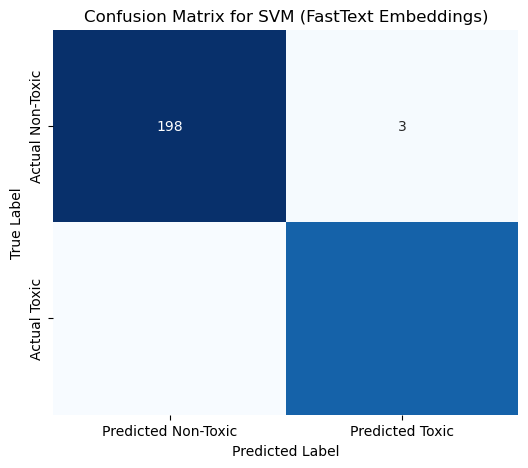


SVM with FastText evaluation complete.


In [19]:
# --- Cell Z: Train and Evaluate SVM with FastText Embeddings ---
import numpy as np
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler # Importazione necessaria per scalare gli embedding
from sklearn.pipeline import Pipeline # Per combinare scaler e classificatore
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

print("\n[STEP] Splitting data for SVM with FastText embeddings...")
# Split the FastText embeddings data into training and testing sets
X_train_ft_svm, X_test_ft_svm, y_train_ft_svm, y_test_ft_svm = train_test_split(
    X_embeddings, y_labels_embeddings, test_size=0.2, random_state=42, stratify=y_labels_embeddings
)
print("[COMPLETED] Data split successfully.")

print("\n[STEP] Setting up Pipeline for SVM with FastText embeddings...")
# Define a pipeline that first scales the embeddings and then applies SVC
pipeline_svm_ft = Pipeline([
    ('scaler', MinMaxScaler()), # Scale embeddings (e.g., to range [0, 1])
    ('clf', SVC(random_state=42, C=1.0, kernel='rbf')) # Initialize SVC with some common parameters
])
# Note: For real-world use, you might want to perform GridSearchCV here as well,
# but for exploration, we'll use sensible defaults or parameters that worked well previously.

print("\n[STEP] Training SVM model with FastText embeddings (this may take some time)...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Ignore potential warnings (e.g., convergence)
    pipeline_svm_ft.fit(X_train_ft_svm, y_train_ft_svm)

print("[COMPLETED] SVM model training finished.")

print("\n[STEP] Evaluating the model performance (SVM with FastText)...")
# Make predictions on the test set using the pipeline
y_pred_svm_ft = pipeline_svm_ft.predict(X_test_ft_svm)

print("\n[COMPLETED] Model evaluation metrics (SVM with FastText):")

# Calculate individual evaluation metrics
accuracy_svm_ft = accuracy_score(y_test_ft_svm, y_pred_svm_ft)
precision_svm_ft = precision_score(y_test_ft_svm, y_pred_svm_ft)
recall_svm_ft = recall_score(y_test_ft_svm, y_pred_svm_ft)
f1_svm_ft = f1_score(y_test_ft_svm, y_pred_svm_ft)

# Display individual metrics
print(f"Overall Accuracy: {accuracy_svm_ft:.4f}")
print(f"Precision (Toxic): {precision_svm_ft:.4f}")
print(f"Recall (Toxic): {recall_svm_ft:.4f}")
print(f"F1-Score (Toxic): {f1_svm_ft:.4f}")

print("\n--- Detailed Classification Report (SVM with FastText) ---")
print(classification_report(y_test_ft_svm, y_pred_svm_ft, target_names=['Non-Toxic (0)', 'Toxic (1)']))

print("\n--- Confusion Matrix (SVM with FastText) ---")
cm_svm_ft = confusion_matrix(y_test_ft_svm, y_pred_svm_ft)
print(cm_svm_ft)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm_ft, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic'])
plt.title('Confusion Matrix for SVM (FastText Embeddings)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nSVM with FastText evaluation complete.")